In [23]:
pip install statsmodels PROPHET

  Using cached holidays-0.81-py3-none-any.whl.metadata (49 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -------------- ------------------------- 4.7/13.3 MB 35.7 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 39.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 32.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [5]:
csv_path = r"t2m_days.csv"

df = pd.read_csv(csv_path, dtype={"date": str})
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df = df.rename(columns={"t2m_mean": "t2m"})
df = df.set_index("date").sort_index()


In [6]:
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(full_idx)
# Interpolação linear para possíveis buracos (temperatura costuma ser suave)
df["t2m"] = df["t2m"].interpolate(limit_direction="both")

In [18]:
print("Resumo estatístico:")
print(df["t2m"].describe(), "\n")


Resumo estatístico:
count    39.000000
mean     23.069667
std       2.703192
min      19.109000
25%      20.211000
50%      22.695000
75%      25.330000
max      27.449000
Name: t2m, dtype: float64 



In [8]:
missing = df["t2m"].isna().sum()
print(f"Valores faltantes após interpolação: {missing}")

Valores faltantes após interpolação: 0


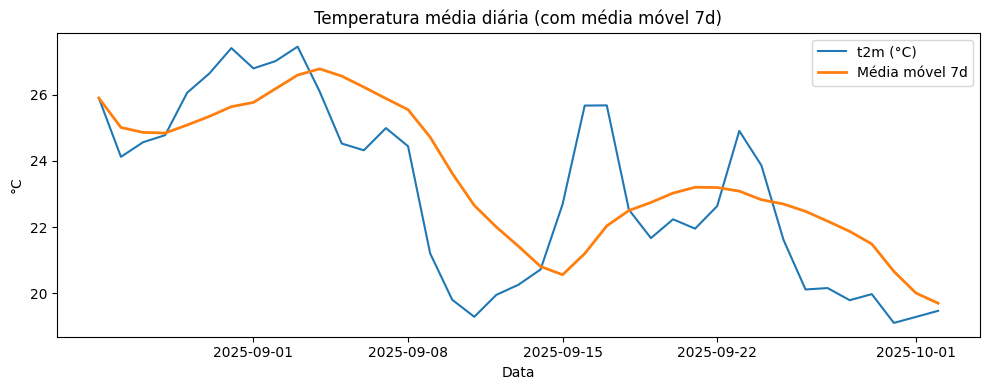

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["t2m"], label="t2m (°C)")
plt.plot(df.index, df["t2m"].rolling(7, min_periods=1).mean(), label="Média móvel 7d", linewidth=2)
plt.title("Temperatura média diária (com média móvel 7d)")
plt.xlabel("Data"); plt.ylabel("°C"); plt.legend()
plt.tight_layout()
plt.show()

C:\Users\ander\AppData\Local\Temp\ipykernel_2704\1868335248.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_dow, labels=["Seg","Ter","Qua","Qui","Sex","Sáb","Dom"], showmeans=True)


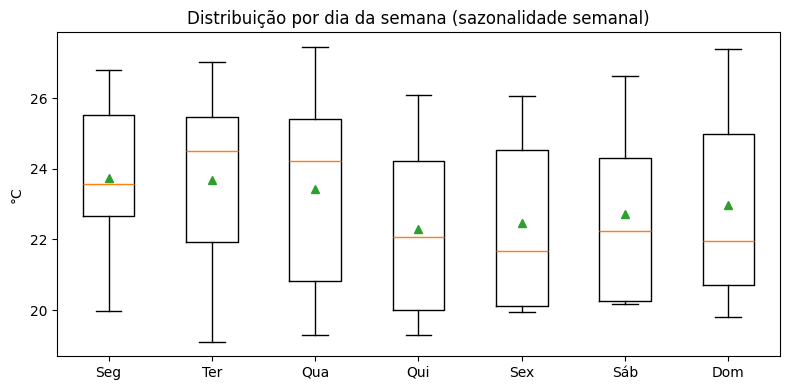

In [10]:
tmp = df.copy()
tmp["dow"] = tmp.index.dayofweek  # 0 = segunda ... 6 = domingo
# Para boxplot, montamos os dados por categoria de dow
data_by_dow = [tmp.loc[tmp["dow"]==d, "t2m"].values for d in range(7)]
plt.figure(figsize=(8,4))
plt.boxplot(data_by_dow, labels=["Seg","Ter","Qua","Qui","Sex","Sáb","Dom"], showmeans=True)
plt.title("Distribuição por dia da semana (sazonalidade semanal)")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

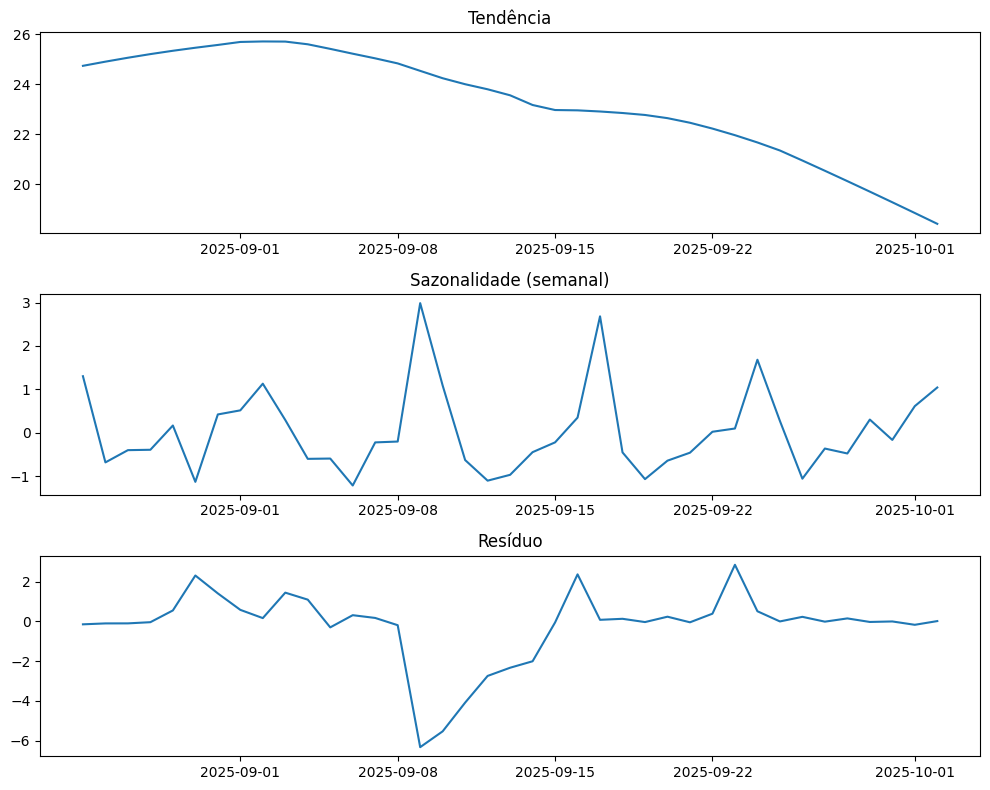

In [11]:
stl = STL(df["t2m"], period=7, robust=True)
res = stl.fit()

plt.figure(figsize=(10,8))
ax1 = plt.subplot(3,1,1); ax1.plot(res.trend); ax1.set_title("Tendência")
ax2 = plt.subplot(3,1,2); ax2.plot(res.seasonal); ax2.set_title("Sazonalidade (semanal)")
ax3 = plt.subplot(3,1,3); ax3.plot(res.resid); ax3.set_title("Resíduo")
plt.tight_layout()
plt.show()

In [12]:
def adf_report(series, name="serie"):
    result = adfuller(series.dropna(), autolag="AIC")
    stat, pvalue, usedlag, nobs, crit, icbest = result
    print(f"=== ADF: {name} ===")
    print(f"Estatística: {stat:.3f} | p-valor: {pvalue:.4f} | lags: {usedlag} | n: {nobs}")
    print("Críticos:", crit, "\n")

adf_report(df["t2m"], "t2m (original)")
adf_report(res.resid, "resíduo STL")

=== ADF: t2m (original) ===
Estatística: -1.274 | p-valor: 0.6410 | lags: 2 | n: 36
Críticos: {'1%': np.float64(-3.626651907578875), '5%': np.float64(-2.9459512825788754), '10%': np.float64(-2.6116707716049383)} 

=== ADF: resíduo STL ===
Estatística: -2.563 | p-valor: 0.1008 | lags: 0 | n: 38
Críticos: {'1%': np.float64(-3.6155091011809297), '5%': np.float64(-2.941262357486514), '10%': np.float64(-2.6091995013850418)} 



<Figure size 1000x400 with 0 Axes>

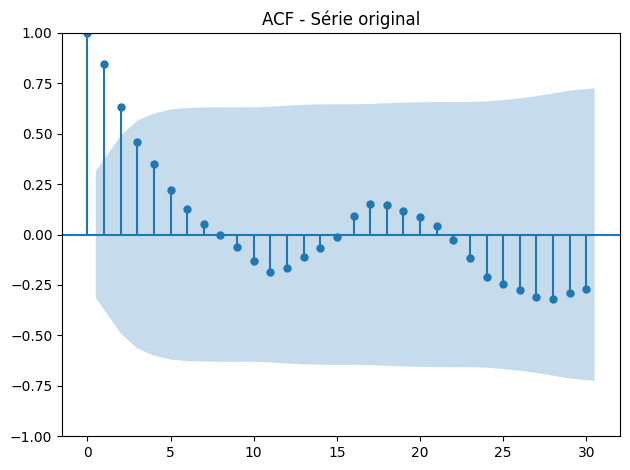

In [17]:
lags = min(30, len(df)-2)

plt.figure(figsize=(10,4))
plot_acf(df["t2m"], lags=lags)
plt.title("ACF - Série original")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

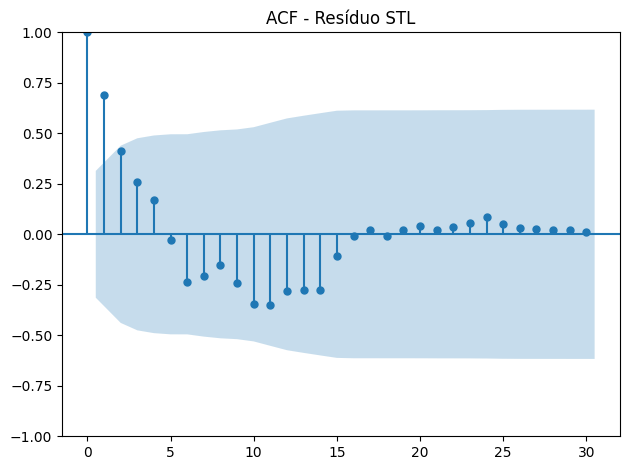

In [16]:
plt.figure(figsize=(10,4))
plot_acf(res.resid.dropna(), lags=lags)
plt.title("ACF - Resíduo STL")
plt.tight_layout()
plt.show()

In [15]:
z = (df["t2m"] - df["t2m"].mean()) / df["t2m"].std(ddof=0)
outliers = df[np.abs(z) > 3]
print(f"Nº de possíveis outliers (>|3σ|): {len(outliers)}")
if len(outliers):
    print(outliers)

Nº de possíveis outliers (>|3σ|): 0


# Treino

## NAIVE x SARIMA x S-Naive

In [28]:
# PASSO 2 — Modelagem (SARIMA) + Validação Walk-Forward + Forecast T+1..T+3

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from itertools import product
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX

# =========================
# 0) Utilidades
# =========================
def load_series(csv_path):
    df = pd.read_csv(csv_path, dtype={"date": str})
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
    df = df.rename(columns={"t2m_mean": "t2m"})
    df = df.set_index("date").sort_index()

    # índice diário contínuo + interpolação suave
    idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    df = df.reindex(idx)
    df["t2m"] = df["t2m"].interpolate(limit_direction="both")
    return df["t2m"]

def mae(y_true, y_pred):
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))

def rmse(y_true, y_pred):
    return sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

def seasonal_naive(history, m, steps):
    """Repete os últimos valores do mesmo ponto da estação."""
    hist = np.asarray(history)
    out = []
    for h in range(1, steps+1):
        out.append(hist[-m + (h-1) % m])
    return np.array(out)

# =========================
# 1) Carregar dados
# =========================
CSV_PATH = r"t2m_days.csv"
y = load_series(CSV_PATH)
m = 7  # sazonalidade semanal para dados diários

print(f"Nº de pontos após preparo: {len(y)} | Início: {y.index.min().date()} | Fim: {y.index.max().date()}")

# =========================
# 2) Seleção de ordem SARIMA por AIC (grade pequena)
#    Mantemos d=1 (tendência), D ∈ {0,1}. p,q ∈ {0,1,2}, P,Q ∈ {0,1}
# =========================
def select_sarima_order(series, m=7):
    best_aic = np.inf
    best = None
    # grades pequenas para evitar overfitting
    for (p,d,q) in product([0,1,2], [1], [0,1,2]):
        for (P,D,Q) in product([0,1], [0,1], [0,1]):
            try:
                mod = SARIMAX(series,
                              order=(p,d,q),
                              seasonal_order=(P,D,Q,m),
                              trend="n",
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                res = mod.fit(disp=False)
                aic = res.aic
                if aic < best_aic:
                    best_aic = aic
                    best = (p,d,q,P,D,Q)
            except Exception:
                continue
    return best, best_aic

best_order, best_aic = select_sarima_order(y, m)
if best_order is None:
    raise RuntimeError("Não foi possível ajustar nenhum SARIMA; ajuste a grade.")
(p,d,q,P,D,Q) = best_order
print(f"Melhor SARIMA por AIC: order=({p},{d},{q}) x ({P},{D},{Q})[{m}] | AIC={best_aic:.1f}")

# =========================
# 3) Walk-Forward Validation (h=3)
#    - Mantemos a ordem acima fixa em todas as dobras
#    - Últimos 'n_test' dias como janela de teste
# =========================
def wf_validate(series, order, m=7, n_test=10, horizon=3):
    (p,d,q,P,D,Q) = order
    n = len(series)
    n_test = min(n_test, n-21)  # garante janela de treino inicial razoável
    start_test = n - n_test

    metrics = {1: [], 2: [], 3: []}
    metrics_naive = {1: [], 2: [], 3: []}
    metrics_snaive = {1: [], 2: [], 3: []}

    for i in range(0, n_test - horizon + 1):
        train = series.iloc[: start_test + i]
        test_window = series.iloc[start_test + i : start_test + i + horizon]

        # SARIMA
        model = SARIMAX(train,
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,m),
                        trend="n",
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
        fc = res.get_forecast(steps=horizon).predicted_mean.values

        # Baselines
        naive_fc = np.repeat(train.iloc[-1], horizon)
        snaive_fc = seasonal_naive(train.values, m=m, steps=horizon)

        # métricas por horizonte
        for h in [1,2,3]:
            yt = test_window.iloc[h-1]
            metrics[h].append(abs(yt - fc[h-1]))
            metrics_naive[h].append(abs(yt - naive_fc[h-1]))
            metrics_snaive[h].append(abs(yt - snaive_fc[h-1]))

    # agrega (MAE por horizonte)
    out = {h: np.mean(metrics[h]) for h in [1,2,3]}
    out_naive = {h: np.mean(metrics_naive[h]) for h in [1,2,3]}
    out_snaive = {h: np.mean(metrics_snaive[h]) for h in [1,2,3]}

    return out, out_naive, out_snaive

mae_sarima, mae_naive, mae_snaive = wf_validate(y, best_order, m=m, n_test=10, horizon=3)
print("\nMAE médio por horizonte (walk-forward, últimos ~10 dias):")
print(f"  SARIMA  : h1={mae_sarima[1]:.3f}, h2={mae_sarima[2]:.3f}, h3={mae_sarima[3]:.3f}")
print(f"  Naive   : h1={mae_naive[1]:.3f},  h2={mae_naive[2]:.3f},  h3={mae_naive[3]:.3f}")
print(f"  S-Naive : h1={mae_snaive[1]:.3f}, h2={mae_snaive[2]:.3f}, h3={mae_snaive[3]:.3f}")

# =========================
# 4) Treina no conjunto completo e prevê T+1..T+3
# =========================
final_model = SARIMAX(y,
                      order=(p,d,q),
                      seasonal_order=(P,D,Q,m),
                      trend="n",
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_res = final_model.fit(disp=False)

h = 3
forecast_res = final_res.get_forecast(steps=h)
fc_mean = forecast_res.predicted_mean
ci80 = forecast_res.conf_int(alpha=0.20)  # 80%
ci95 = forecast_res.conf_int(alpha=0.05)  # 95%

# monta tabela amigável
next_dates = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=h, freq="D")
df_fc = pd.DataFrame({
    "date": next_dates,
    "forecast": fc_mean.values,
    "lo80": ci80.iloc[:,0].values,
    "hi80": ci80.iloc[:,1].values,
    "lo95": ci95.iloc[:,0].values,
    "hi95": ci95.iloc[:,1].values
})
print("\nPrevisão SARIMA (treinado em toda a série):")
print(df_fc.round(3).to_string(index=False))


Nº de pontos após preparo: 998 | Início: 2023-01-08 | Fim: 2025-10-01
Melhor SARIMA por AIC: order=(2,1,2) x (1,0,1)[7] | AIC=3309.6

MAE médio por horizonte (walk-forward, últimos ~10 dias):
  SARIMA  : h1=1.027, h2=1.889, h3=2.401
  Naive   : h1=1.040,  h2=1.618,  h3=1.933
  S-Naive : h1=1.712, h2=2.375, h3=2.785

Previsão SARIMA (treinado em toda a série):
      date  forecast   lo80   hi80   lo95   hi95
2025-10-02    20.098 18.452 21.744 17.581 22.615
2025-10-03    20.560 17.826 23.294 16.379 24.741
2025-10-04    20.840 17.592 24.088 15.873 25.807


## PROPHET

In [29]:
# Prophet: validação walk-forward + previsão T+1..T+3
# Arquivo esperado: POWER\T2M\DAYS\t2m_days.csv (colunas: date,t2m_mean com date=YYYYMMDD)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from math import sqrt

# ---- 1) Utilidades
def load_series(csv_path):
    df = pd.read_csv(csv_path, dtype={"date": str})
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
    df = df.rename(columns={"t2m_mean": "t2m"})
    df = df.set_index("date").sort_index()

    # índice diário contínuo + interpolação suave
    idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    df = df.reindex(idx)
    df["t2m"] = df["t2m"].interpolate(limit_direction="both")
    return df["t2m"]

def mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def seasonal_naive(history, m, steps):
    hist = np.asarray(history)
    return np.array([hist[-m + (h % m)] for h in range(steps)])

# ---- 2) Carregar série
CSV_PATH = r"t2m_days.csv"
y = load_series(CSV_PATH)
print(f"N pontos: {len(y)} | {y.index.min().date()} → {y.index.max().date()}")

# ---- 3) Prophet (config conservadora p/ série curta)
from prophet import Prophet

def fit_prophet(series):
    dfp = pd.DataFrame({"ds": series.index, "y": series.values})
    # Série curta: só sazonalidade semanal; desligamos anual e diária
    m = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,  # suave
    )
    m.fit(dfp)
    return m

def prophet_forecast(model, horizon):
    future = model.make_future_dataframe(periods=horizon, freq="D", include_history=False)
    fc = model.predict(future)[["ds","yhat","yhat_lower","yhat_upper"]]
    return fc

# ---- 4) Walk-forward validation (comparar com Naive)
def wf_validate_prophet(series, n_test=10, horizon=3):
    n = len(series)
    n_test = min(n_test, n-21)  # garante treino inicial com ~>=21 pontos
    start_test = n - n_test

    mae_prophet = {1: [], 2: [], 3: []}
    mae_naive   = {1: [], 2: [], 3: []}

    for i in range(0, n_test - horizon + 1):
        train = series.iloc[: start_test + i]
        test  = series.iloc[start_test + i : start_test + i + horizon]

        # Prophet
        model = fit_prophet(train)
        fc = prophet_forecast(model, horizon)
        # alinhar
        yhat = fc["yhat"].values

        # Naive
        naive_fc = np.repeat(train.iloc[-1], horizon)

        for h in [1,2,3]:
            yt = test.iloc[h-1]
            mae_prophet[h].append(abs(yt - yhat[h-1]))
            mae_naive[h].append(abs(yt - naive_fc[h-1]))

    avg_prophet = {h: float(np.mean(mae_prophet[h])) for h in [1,2,3]}
    avg_naive   = {h: float(np.mean(mae_naive[h]))   for h in [1,2,3]}
    return avg_prophet, avg_naive

mae_prophet, mae_naive = wf_validate_prophet(y, n_test=10, horizon=3)
print("\nMAE médio por horizonte (walk-forward, ~últimos 10 dias):")
print(f"  Prophet: h1={mae_prophet[1]:.3f}, h2={mae_prophet[2]:.3f}, h3={mae_prophet[3]:.3f}")
print(f"  Naive  : h1={mae_naive[1]:.3f},  h2={mae_naive[2]:.3f},  h3={mae_naive[3]:.3f}")

# ---- 5) Treinar no conjunto completo e prever +3 dias
final_model = fit_prophet(y)
fc = prophet_forecast(final_model, horizon=3)

# Renomear e mostrar
fc = fc.rename(columns={"ds":"date", "yhat":"forecast", "yhat_lower":"lo95", "yhat_upper":"hi95"})
print("\nPrevisão Prophet (próximos 3 dias, intervalos ~95%):")
print(fc.to_string(index=False, formatters={"forecast": "{:.3f}".format,
                                            "lo95": "{:.3f}".format,
                                            "hi95": "{:.3f}".format}))

# ---- 6) (Opcional) salvar/carregar o modelo
# from joblib import dump, load
# dump(final_model, "prophet_model.pkl")
# model_loaded = load("prophet_model.pkl")
# fc_loaded = prophet_forecast(model_loaded, horizon=3)


17:02:02 - cmdstanpy - INFO - Chain [1] start processing


N pontos: 998 | 2023-01-08 → 2025-10-01


17:02:02 - cmdstanpy - INFO - Chain [1] done processing
17:02:02 - cmdstanpy - INFO - Chain [1] start processing
17:02:03 - cmdstanpy - INFO - Chain [1] done processing
17:02:03 - cmdstanpy - INFO - Chain [1] start processing
17:02:03 - cmdstanpy - INFO - Chain [1] done processing
17:02:03 - cmdstanpy - INFO - Chain [1] start processing
17:02:03 - cmdstanpy - INFO - Chain [1] done processing
17:02:03 - cmdstanpy - INFO - Chain [1] start processing
17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing
17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing
17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing
17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing
17:02:04 - cmdstanpy - INFO - Chain [1] done processing



MAE médio por horizonte (walk-forward, ~últimos 10 dias):
  Prophet: h1=1.844, h2=1.879, h3=1.645
  Naive  : h1=1.040,  h2=1.618,  h3=1.933

Previsão Prophet (próximos 3 dias, intervalos ~95%):
      date forecast   lo95   hi95
2025-10-02   21.435 18.303 24.388
2025-10-03   21.535 18.427 24.609
2025-10-04   21.722 18.749 24.899


##### PREDIÇÃO FINAL

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Union, Optional, Tuple
from joblib import dump, load

# Prophet
from prophet import Prophet

def _prep_series(obj: Union[str, Path, pd.DataFrame, pd.Series]) -> pd.Series:
    """
    Aceita: caminho p/ CSV (colunas: date,t2m_mean, date=YYYYMMDD),
            DataFrame com colunas ['date','t2m_mean'],
            ou Series com índice datetime.
    Retorna uma pd.Series diária contínua, index=datetime, coluna única (t2m).
    """
    if isinstance(obj, (str, Path)):
        df = pd.read_csv(str(obj), dtype={"date": str})
    elif isinstance(obj, pd.DataFrame):
        df = obj.copy()
    elif isinstance(obj, pd.Series):
        s = obj.copy()
        if not isinstance(s.index, pd.DatetimeIndex):
            raise ValueError("A Series precisa ter índice datetime.")
        df = s.to_frame(name="t2m")
        df["date"] = df.index
    else:
        raise ValueError("Tipo de entrada não suportado.")

    # normaliza colunas
    if "date" not in df.columns:
        raise ValueError("Esperado campo 'date' na entrada.")
    if "t2m_mean" in df.columns and "t2m" not in df.columns:
        df = df.rename(columns={"t2m_mean": "t2m"})
    if "t2m" not in df.columns:
        raise ValueError("Esperado campo 't2m_mean' (ou 't2m') na entrada.")

    # parse datas (YYYYMMDD)
    if not np.issubdtype(df["date"].dtype, np.datetime64):
        df["date"] = pd.to_datetime(df["date"].astype(str), format="%Y%m%d", errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date").set_index("date")

    # garante frequência diária contínua + interpolação suave
    idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    df = df.reindex(idx)
    df["t2m"] = df["t2m"].interpolate(limit_direction="both")
    return df["t2m"]

def _fit_prophet(series: pd.Series) -> Prophet:
    """Prophet com sazonalidade semanal + anual (ideal p/ clima com anos de histórico)."""
    dfp = pd.DataFrame({"ds": series.index, "y": series.values})
    m = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,  # suave para evitar sobreajuste
    )
    m.fit(dfp)
    return m

def forecast3_hybrid(
    data: Union[str, Path, pd.DataFrame, pd.Series],
    prophet_model_path: Optional[Union[str, Path]] = None,
    save_trained_model_to: Optional[Union[str, Path]] = None,
    return_as_csv_string: bool = True,
    round_decimals: int = 3,
) -> Union[str, Tuple[float, float, float]]:
    """
    HÍBRIDO: Naive (T+1) + Prophet (T+2, T+3).
    - Se `prophet_model_path` for fornecido e existir, o Prophet é carregado.
    - Caso contrário, o Prophet é treinado nos dados e (opcionalmente) salvo em `save_trained_model_to`.
    Retorna: string "v1,v2,v3" ou tupla (v1, v2, v3).
    """
    y = _prep_series(data)
    if len(y) < 14:
        # com pouquíssimos pontos o Prophet pode instabilizar; ainda assim tentamos
        warnings.warn("Série muito curta (<14 pontos). Resultados podem ser instáveis.")

    # T+1 (Naive)
    t1 = float(y.iloc[-1])

    # Prophet para T+2 e T+3
    model: Optional[Prophet] = None
    if prophet_model_path and Path(prophet_model_path).exists():
        model = load(prophet_model_path)
    else:
        model = _fit_prophet(y)
        if save_trained_model_to is not None:
            dump(model, save_trained_model_to)

    future = model.make_future_dataframe(periods=3, freq="D", include_history=False)
    fc = model.predict(future)[["ds", "yhat"]].sort_values("ds").reset_index(drop=True)

    # yhat[0] é T+1 do Prophet — mas usamos Naive para T+1.
    # Logo, tomamos T+2 = yhat[1], T+3 = yhat[2].
    if len(fc) < 3:
        raise RuntimeError("O Prophet não retornou 3 passos de previsão.")

    t2 = float(fc.loc[1, "yhat"])
    t3 = float(fc.loc[2, "yhat"])

    if return_as_csv_string:
        return f"{round(t1, round_decimals)},{round(t2, round_decimals)},{round(t3, round_decimals)}"
    else:
        # valores brutos (sem arredondar)
        return (t1, t2, t3)

# -------------------------
# EXEMPLOS DE USO
# -------------------------
# 1) Entrada por caminho p/ CSV:
# print(forecast3_hybrid(r"POWER\T2M\DAYS\t2m_days.csv",
#                        prophet_model_path="prophet_model.pkl",         # opcional (carrega)
#                        save_trained_model_to="prophet_model.pkl",       # opcional (salva)
#                        return_as_csv_string=True))

# 2) Entrada por DataFrame (se você já tiver em memória):
df = pd.read_csv(r"t2m_days.csv", dtype={"date": str})
print(forecast3_hybrid(df))

# 3) Retornar tupla de floats em vez de string:
#int(forecast3_hybrid(r"t2m_days.csv", return_as_csv_string=False))


17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:46 - cmdstanpy - INFO - Chain [1] done processing
17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:46 - cmdstanpy - INFO - Chain [1] done processing


19.37,21.535,21.722
(19.37, 21.53533287735426, 21.721634215332408)
